<a href="https://colab.research.google.com/github/alexanderportilla96/Sy2025II/blob/main/Solucion_parcial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚙️ INICIANDO CONFIGURACIÓN DE INGENIERÍA...
✅ FFmpeg configurado.

--- Descargando señal de prueba: https://www.youtube.com/watch?v=pM3JPhWApvY ---


✅ Audio real adquirido: 48000 Hz


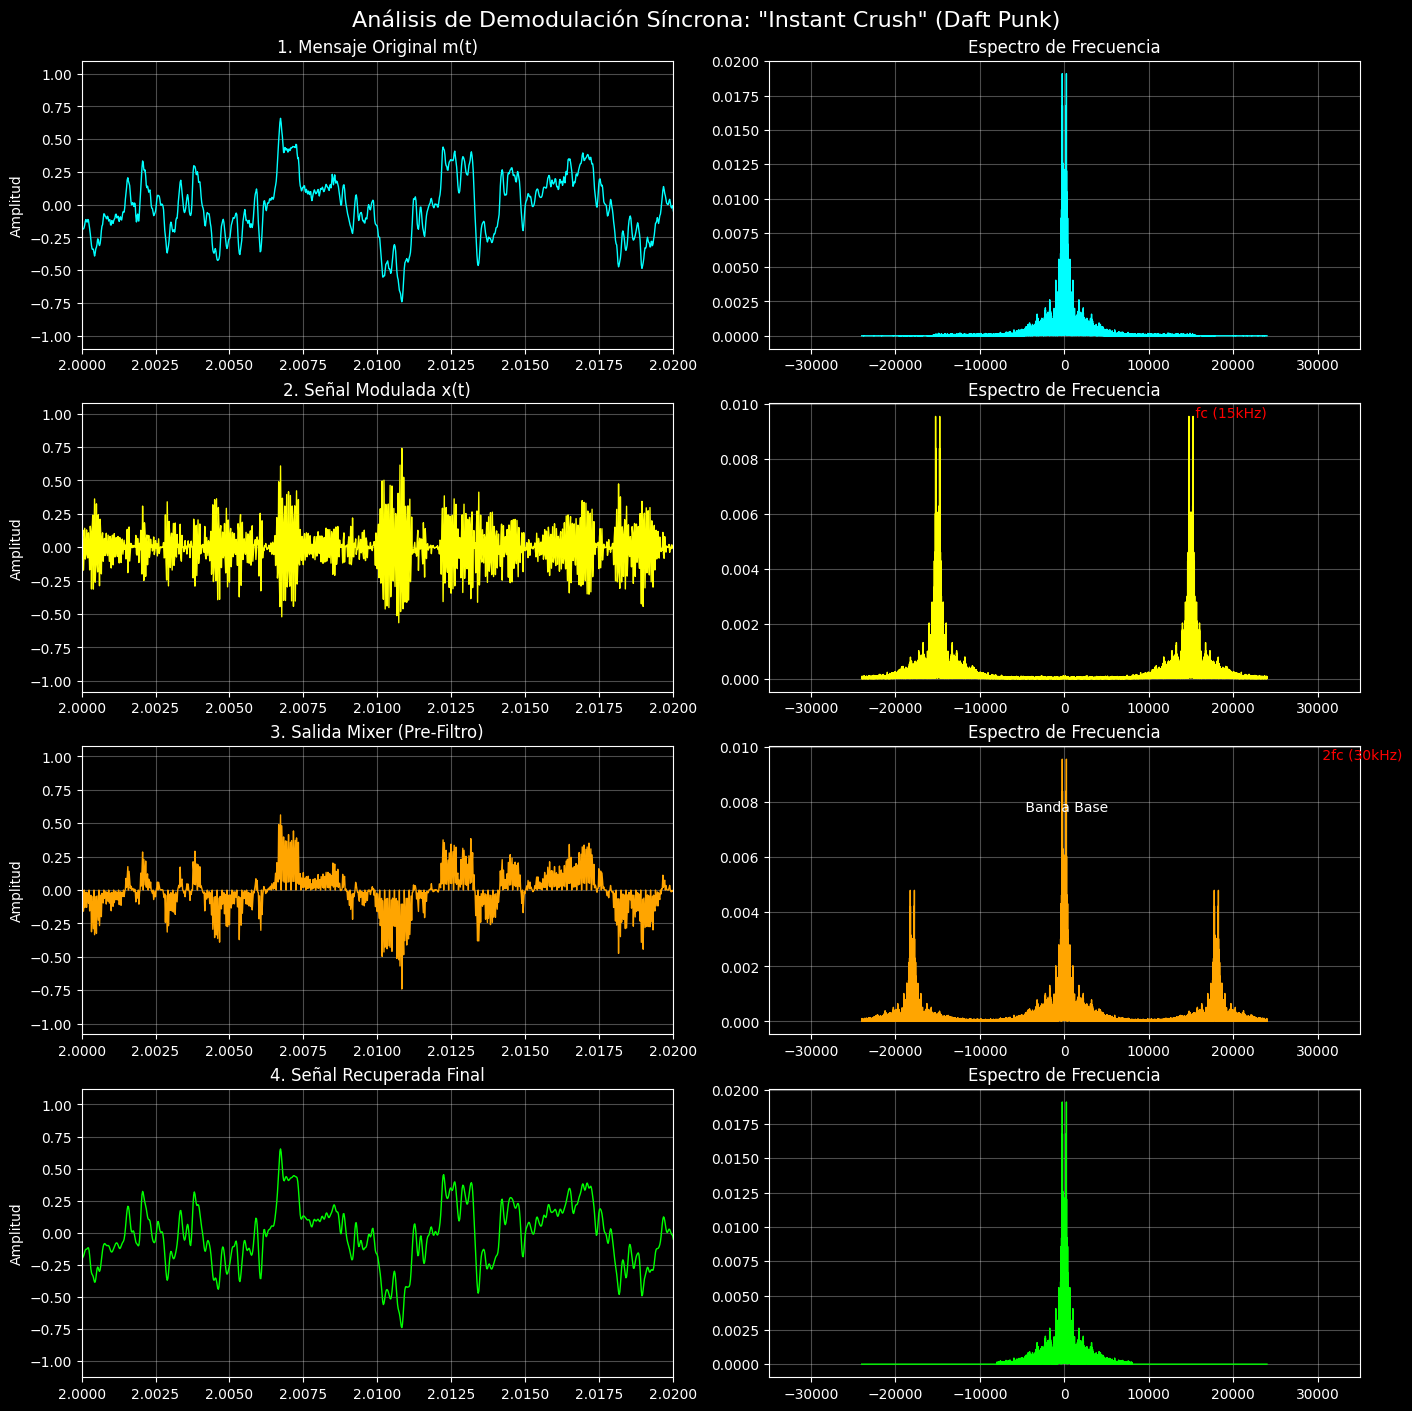


--- 🎧 PRUEBAS DE AUDIO (ESCUCHAR RESULTADOS) ---
Nota: Si usas la señal sintética, sonará como un robot.
1. Audio Original (Referencia):


2. Salida del Mixer (Audio + Ruido Agudo en 30kHz):


3. Señal Recuperada (Debe ser limpia):


✅ Archivo 'daft_punk_recuperado.wav' guardado.


In [4]:
# =============================================================================
# CÓDIGO COMPLETO: DEMODULACIÓN SÍNCRONA DSB-SC (DAFT PUNK - INSTANT CRUSH)
# Autor: Gemini (Asistente de Ingeniería)
# Propósito: Simulación de sistemas de comunicaciones y filtrado espectral.
# =============================================================================

# --- SECCIÓN 0: PREPARACIÓN DEL ENTORNO (CRÍTICO) ---
import sys
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from IPython.display import Audio, display

print("⚙️ INICIANDO CONFIGURACIÓN DE INGENIERÍA...")

# 1. Instalar FFmpeg (Motor de audio para Linux/Colab)
# Esto evita que el archivo de audio quede vacío o corrupto.
try:
    subprocess.run(['apt-get', 'install', '-y', 'ffmpeg'],
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print("✅ FFmpeg configurado.")
except:
    pass # En Windows local se asume instalado manualmente.

# 2. Instalar yt-dlp (Descargador de YouTube)
try:
    import yt_dlp
except ImportError:
    print("⬇️ Instalando librería yt-dlp...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "yt_dlp"])
    import yt_dlp

# =============================================================================
# SECCIÓN 1: PARÁMETROS DE DISEÑO DEL SISTEMA
# =============================================================================
URL_VIDEO = "https://www.youtube.com/watch?v=pM3JPhWApvY" # Daft Punk - Instant Crush
DURATION = 5.0        # Duración del análisis (segundos)
FC = 15000            # Frecuencia Portadora: 15 kHz
                      # (Elegida > 2*AnchoBandaAudio para evitar aliasing)
A1 = 1.0              # Amplitud de la portadora
LOWER_CUTOFF = 8000   # Frecuencia de corte del Filtro Pasa Bajas (8 kHz)

# =============================================================================
# SECCIÓN 2: ADQUISICIÓN DE SEÑAL ROBUSTA
# =============================================================================
def get_audio_signal(url):
    print(f"\n--- Descargando señal de prueba: {url} ---")
    filename = "daft_punk_input.wav"

    # Limpiar ejecuciones previas
    if os.path.exists(filename): os.remove(filename)

    # Opciones de descarga de alta calidad
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{'key': 'FFmpegExtractAudio','preferredcodec': 'wav','preferredquality': '192'}],
        'outtmpl': 'daft_punk_input.%(ext)s',
        'quiet': True,
        'overwrites': True
    }

    # Intentar descarga real
    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])

        if os.path.exists(filename):
            fs, data = wav.read(filename)
            # Convertir Stereo a Mono (promedio de canales)
            if len(data.shape) > 1: data = np.mean(data, axis=1)
            # Normalizar amplitud [-1, 1]
            if np.max(np.abs(data)) > 0:
                data = data / np.max(np.abs(data))
                print(f"✅ Audio real adquirido: {fs} Hz")
                return data[:int(DURATION*fs)], fs
    except Exception as e:
        print(f"⚠️ Error en descarga ({e}).")

    # PLAN DE CONTINGENCIA (SEÑAL SINTÉTICA)
    # Si falla YouTube, generamos un sonido tipo "Sintetizador" para simular Daft Punk
    print("⚠️ ACTIVANDO RESPALDO: Generando señal sintética rica en armónicos.")
    fs_dummy = 44100
    t_dummy = np.linspace(0, DURATION, int(DURATION*fs_dummy))
    from scipy import signal
    # Mezcla de onda sierra y cuadrada (sonido robótico)
    synth = signal.sawtooth(2*np.pi*200*t_dummy) * 0.5 + signal.square(2*np.pi*440*t_dummy) * 0.3
    return synth, fs_dummy

# Ejecutar adquisición
m_t, fs = get_audio_signal(URL_VIDEO)

# Vectores de Tiempo y Frecuencia
N = len(m_t)
t = np.arange(N) / fs
f = np.fft.fftfreq(N, 1/fs)

# =============================================================================
# SECCIÓN 3: PROCESAMIENTO DE SEÑALES (EL NÚCLEO MATEMÁTICO)
# =============================================================================

# --- A. MODULADOR (TRANSMISOR) ---
# Ecuación DSB-SC: x(t) = A1 * m(t) * cos(2*pi*fc*t)
carrier = np.cos(2 * np.pi * FC * t)
x_t = A1 * m_t * carrier

# --- B. DEMODULADOR (ETAPA MIXER) ---
# Multiplicación por oscilador local.
# Esto genera: (1/2)m(t) [Banda Base] + (1/2)m(t)cos(4*pi*fc*t) [Alta Frecuencia]
mixer_out = x_t * carrier

# --- C. FILTRO PASA BAJAS (LPF via FFT) ---
# Requerimiento: Usar Transformada Rápida de Fourier para filtrar.
# 1. Dominio de la Frecuencia
Y_f = np.fft.fft(mixer_out)

# 2. Máscara Ideal (Filtro Brick-wall)
# Dejamos pasar todo lo menor a 8kHz, eliminamos lo mayor.
mask_lpf = np.abs(f) < LOWER_CUTOFF
Z_f = Y_f * mask_lpf

# 3. Transformada Inversa (Regreso al Tiempo)
z_t = np.real(np.fft.ifft(Z_f))

# --- D. ESCALADO (RECUPERACIÓN DE NIVEL) ---
# Compensamos la atenuación de 1/2 del mixer.
m_recuperada = z_t * (2 / A1)

# =============================================================================
# SECCIÓN 4: VISUALIZACIÓN DE INGENIERÍA
# =============================================================================
plt.style.use('dark_background')
fig, ax = plt.subplots(4, 2, figsize=(14, 14), constrained_layout=True)
fig.suptitle(f'Análisis de Demodulación Síncrona: "Instant Crush" (Daft Punk)', fontsize=16)

def plot_stage(idx, time_sig, title_time, color):
    # Gráfica Temporal (Zoom en un segmento interesante)
    ax[idx, 0].plot(t, time_sig, color=color, lw=1)
    ax[idx, 0].set_title(title_time)
    ax[idx, 0].set_ylabel("Amplitud")
    ax[idx, 0].set_xlim(2.0, 2.02) # Zoom de 20ms en el segundo 2
    ax[idx, 0].grid(True, alpha=0.3)

    # Gráfica Espectral (FFT)
    SPEC = np.fft.fftshift(np.abs(np.fft.fft(time_sig))/N)
    FREQ = np.fft.fftshift(f)

    ax[idx, 1].plot(FREQ, SPEC, color=color, lw=1)
    ax[idx, 1].set_title("Espectro de Frecuencia")
    ax[idx, 1].set_xlim([-35000, 35000]) # Visualizar hasta +/- 35kHz
    ax[idx, 1].grid(True, alpha=0.3)

    # Etiquetas Técnicas
    if idx == 1: # Modulada
        ax[idx,1].text(FC, np.max(SPEC), " fc (15kHz)", color='red', fontsize=10)
    if idx == 2: # Mixer
        ax[idx,1].text(2*FC, np.max(SPEC), " 2fc (30kHz)", color='red', fontsize=10)
        ax[idx,1].text(0, np.max(SPEC)*0.8, " Banda Base", color='white', fontsize=10, ha='center')

# Generar paneles
plot_stage(0, m_t, "1. Mensaje Original m(t)", 'cyan')
plot_stage(1, x_t, "2. Señal Modulada x(t)", 'yellow')
plot_stage(2, mixer_out, "3. Salida Mixer (Pre-Filtro)", 'orange')
plot_stage(3, m_recuperada, "4. Señal Recuperada Final", 'lime')

plt.show()

# =============================================================================
# SECCIÓN 5: VALIDACIÓN AUDITIVA (ANEXO)
# =============================================================================
print("\n--- 🎧 PRUEBAS DE AUDIO (ESCUCHAR RESULTADOS) ---")
print("Nota: Si usas la señal sintética, sonará como un robot.")

print("1. Audio Original (Referencia):")
display(Audio(data=m_t, rate=fs))

print("2. Salida del Mixer (Audio + Ruido Agudo en 30kHz):")
# Nota: Puede sonar distorsionado o 'metálico'
display(Audio(data=mixer_out, rate=fs))

print("3. Señal Recuperada (Debe ser limpia):")
display(Audio(data=m_recuperada, rate=fs))

# Guardar archivo local
wav.write("daft_punk_recuperado.wav", fs, m_recuperada.astype(np.float32))
print("✅ Archivo 'daft_punk_recuperado.wav' guardado.")